# Final Project- Persuasive Analysis

### By Omar Darwish and Zander Henson

The COVID pandemic was a crazy time both domestically and internationally, with both citizens and healthcare leaders scrambling to decide what actions to take for the good of themselves and society at large. For this reason, it became vital that any pandemic response would be data-driven for maximal efficacy. Having predictions for the infectiousness (R factor and K factor) gave epidemiologists tools and metrics to make suggestions about potential lockdown policies. Unfortunately, these models didn't fully capture the nuanced picture of how a pandemic would impact communities based on demographic factors and comorbidities like a weakened immune system. Additionally, the generic response left people in the dark about the specific risks to them and their families.

Our analysis attempts to answer the question of whether we can predict the number/proportion of deaths in a community based on age group and condition. We sourced our data from a government dataset put together by the department of health and human services. It contained information about covid deaths within different states partitioned by date, state, age group, and medical condition. We chose to use a decision tree (supervised learning) on our dataset because it allowed us to get numerical predictions that could be used to make sense of relative risk in different communities, rather than just forming clusters based on age, condition, and death totals. We ended up discovering that there was a definite pattern in the data that was explainable with the factors that we analyzed.

In [1]:
# Importing necessary libraries
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import graphviz
from graphviz import Source
from IPython.display import display, Image
encoder = LabelEncoder()

The source of this data was https://catalog.data.gov/dataset/conditions-contributing-to-deaths-involving-coronavirus-disease-2019-covid-19-by-age-group

It contains date columns, location information, condition info (ICD10_codes which just encodes the condition column), age group, and deaths.

In [2]:
# Loading data
df = pd.read_csv("C:\\Users\\omard\\Downloads\\covid.csv")
df.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Flag
0,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,1569.0,1647.0,NaN
1,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,5804.0,6029.0,NaN
2,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,15080.0,15699.0,NaN
3,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,37414.0,38878.0,NaN
4,09/24/2023,01/01/2020,09/23/2023,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,82668.0,85708.0,NaN


In [3]:
# Dropping
df.drop(columns = ['Data As Of', 'Start Date', 'Year', 'Month', 'ICD10_codes', 'Flag'], inplace = True)
df.head()

,End Date,Group,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Number of Mentions
0,09/23/2023,By Total,United States,Respiratory diseases,Influenza and pneumonia,0-24,1569.0,1647.0
1,09/23/2023,By Total,United States,Respiratory diseases,Influenza and pneumonia,25-34,5804.0,6029.0
2,09/23/2023,By Total,United States,Respiratory diseases,Influenza and pneumonia,35-44,15080.0,15699.0
3,09/23/2023,By Total,United States,Respiratory diseases,Influenza and pneumonia,45-54,37414.0,38878.0
4,09/23/2023,By Total,United States,Respiratory diseases,Influenza and pneumonia,55-64,82668.0,85708.0


In [4]:
# Dropping NA Values
df = df.dropna()
print(df.isnull().sum())

End Date              0
Group                 0
State                 0
Condition Group       0
Condition             0
Age Group             0
COVID-19 Deaths       0
Number of Mentions    0
dtype: int64


Since the data was categorical, we used an encoding for the different disease categories, and later on we do the same with age group.

The main conditions range from minor to severe life-threatening conditions like Malignant Neoplasms (a fancy word for cancer). Since cancer strains the immune system greatly (I can attest to this from familial experience), it would likely be a strong comorbidity of covid death.

In [5]:
# Display different condition groups

df['Condition Group'].unique()


# Map condition groups

condition_map = {
    'Respiratory diseases': 1,
    'Circulatory diseases': 2,
    'Sepsis': 3,
    'Malignant neoplasms': 4,
    'Diabetes': 5,
    'Obesity': 6,
    'Alzheimer disease': 7,
    'Vascular and unspecified dementia': 8,
    'Renal failure': 9,
    'Intentional and unintentional injury, poisoning, and other adverse events': 10,
    'All other conditions and causes (residual)': 11,
    'COVID-19': 12
}

df['Condition Group'] = df['Condition Group'].replace(condition_map)
#df.head()

###### The values for the Condition Group are as follows: 
###### Respiratory Diseases = 1
###### Circulatory Diseases = 2
###### Sepsis = 3
###### Malignant Neoplasms = 4
###### Diabetes = 5
###### Obesity = 6
###### Alzheimer Disease = 7
###### Vascular and Unspecified Dementia = 8
###### Renal Failure = 9
###### Intentional and Unintentional Injury (poisoning, etc.) = 10
###### All other conditions and causes = 11
###### COVID-19 = 12

#### Here we split the data-set into two different data-frames. The first one will be used to train and optimize our model. The second will be used exclusively to test our accuracy on a different sample.
This step is very important since we need to get a reasonable estimate of the model's performance that is outside of our training set (because of overfitting) and even our vaidation/testing set. If we tune hyperparameters like tree depth to fit our model to the testing set, there is information leakage. Selecting a different 2-year section (2022-2023) for our final testing data allows us to backtest without fooling ourselves and the important policy-makers who base their actions on our analysis.

In [6]:
# Convert to proper date format
df['End Date'] = pd.to_datetime(df['End Date'])
df.head()

,End Date,Group,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Number of Mentions
0,2023-09-23,By Total,United States,1,Influenza and pneumonia,0-24,1569.0,1647.0
1,2023-09-23,By Total,United States,1,Influenza and pneumonia,25-34,5804.0,6029.0
2,2023-09-23,By Total,United States,1,Influenza and pneumonia,35-44,15080.0,15699.0
3,2023-09-23,By Total,United States,1,Influenza and pneumonia,45-54,37414.0,38878.0
4,2023-09-23,By Total,United States,1,Influenza and pneumonia,55-64,82668.0,85708.0


In [7]:
# Encoding
age_encoder = LabelEncoder()
df['Age Group'] = age_encoder.fit_transform(df['Age Group'])

# Data for training
training_dataframe = df[df['End Date'].dt.year.isin([2020, 2021])]

# Data for testing
testing_dataframe = df[df['End Date'].dt.year.isin([2022, 2023])]

testing_dataframe.head()

,End Date,Group,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Number of Mentions
0,2023-09-23,By Total,United States,1,Influenza and pneumonia,0,1569.0,1647.0
1,2023-09-23,By Total,United States,1,Influenza and pneumonia,1,5804.0,6029.0
2,2023-09-23,By Total,United States,1,Influenza and pneumonia,2,15080.0,15699.0
3,2023-09-23,By Total,United States,1,Influenza and pneumonia,3,37414.0,38878.0
4,2023-09-23,By Total,United States,1,Influenza and pneumonia,4,82668.0,85708.0


In [8]:
# Prepare the data into features and targets
X = training_dataframe[['Condition Group', 'Age Group']]
y = training_dataframe['COVID-19 Deaths']
y = encoder.fit_transform(y)

X2 = testing_dataframe[['Condition Group', 'Age Group']]
y2 = testing_dataframe['COVID-19 Deaths']
y2 = encoder.fit_transform(y2)

In [9]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Now that the data is fully partitioned, we create our model. We chose to make our tree have a max depth of 3, so it is understandable and actionable to both politicians and individuals who want a rough outline of the risks to their communities. We are more than willing to take the small accuracy trade-off since decision trees branch exponentially and become very complicated very quickly. There isn't much point to a 100 depth decision tree, since it is impossible to extract insights other than the model predictions themselves.

In [10]:
# Initialize
decisiontree_model = DecisionTreeClassifier(random_state = 42, max_depth = 3)

# Fit training sets to the model
decisiontree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

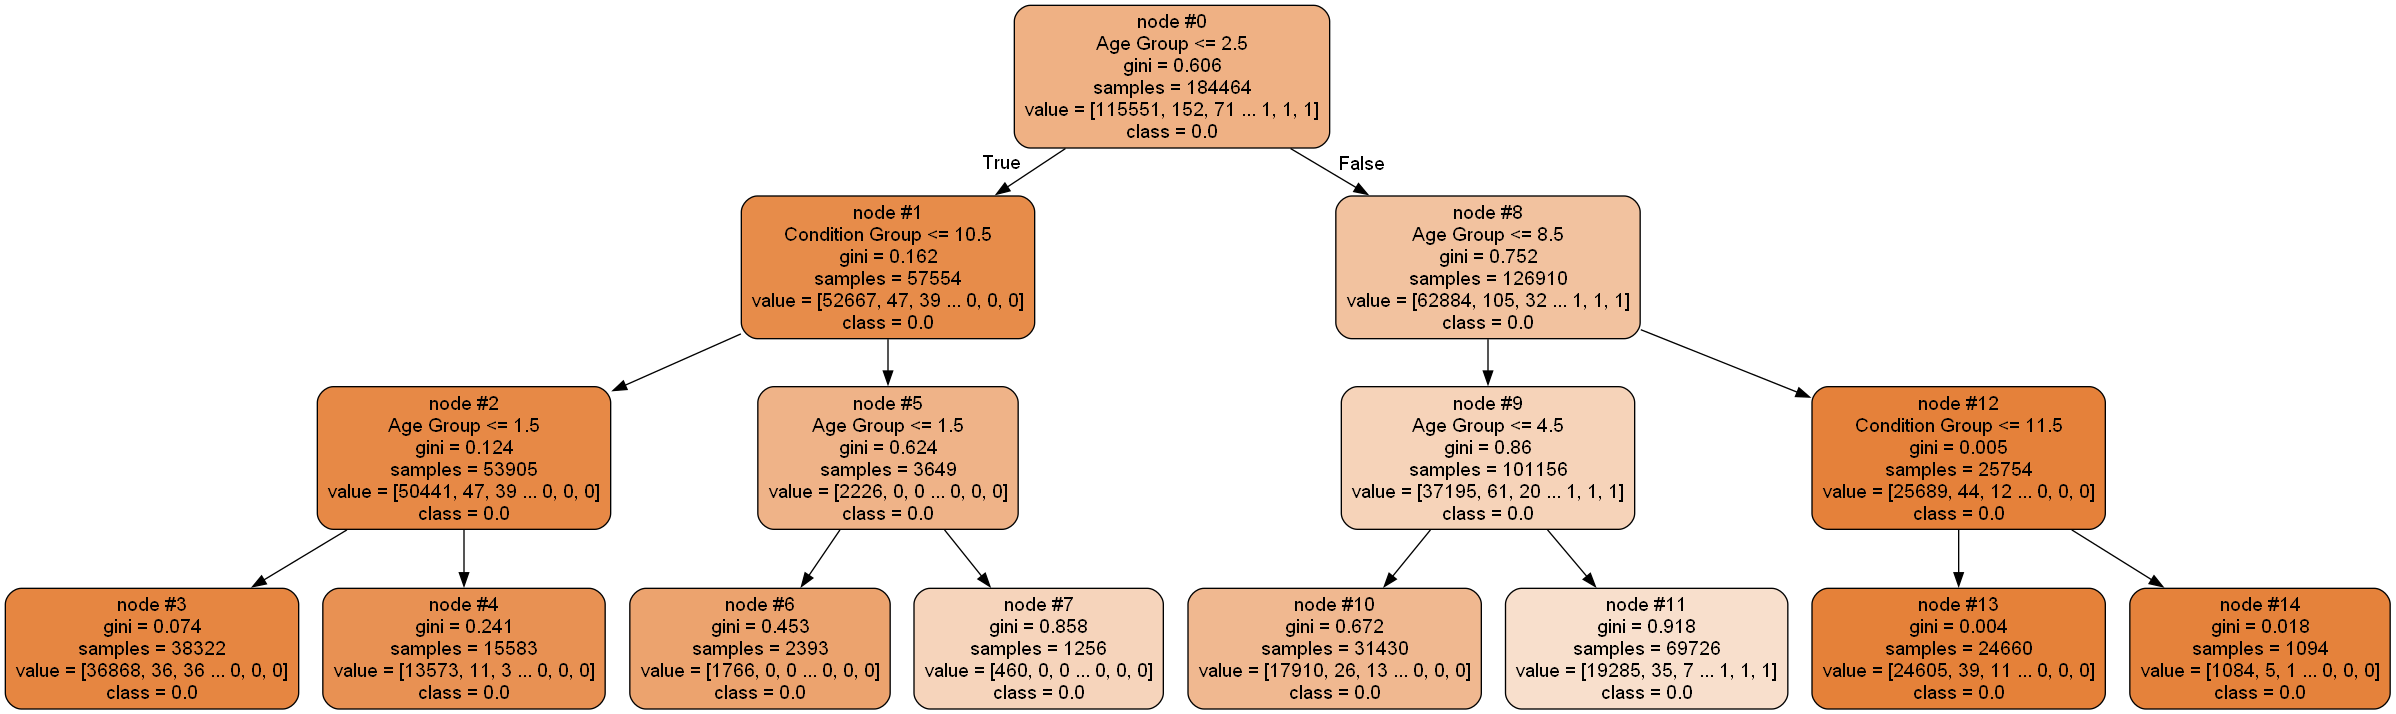

In [11]:
# Plotting the decision tree
dot_data = export_graphviz(decisiontree_model,
                          out_file=None,
                          feature_names=['Condition Group', 'Age Group'],
                          class_names=[str(cls) for cls in encoder.classes_],
                          rounded=True,
                          filled=True,
                          leaves_parallel=True,
                          node_ids=True)

graph = Source(dot_data, format = 'png', engine = 'dot')
graph_saved = graph.render(filename = 'decision_tree_fixed', cleanup = True)
display(Image(filename = 'decision_tree_fixed.png', width = 1800, height = 800))

The first observation we can take away from the tree is that young adults, and even unhealthy young adults are generally resiliant to the severe effects of covid. Counter-intuitively, the youngest in our data had a higher death count than adults aged 25-34. Covid had an unprecented ability to attack and spread through lung cells, so if combined with a pre-existing respiratory condition and the unfinished development of the respiratory system, covid could lead to increased mortality in young patients with conditions. This effect size was not very large though, since the lowest age category included those from 0-24, which should include about twice as many people as the other age ranges.

Another finding was that the highest age groups were at most risk from covid. This is not a surprise to anyone who anyone who followed the news about the pandemic, since elderly communities such as nursing homes and care facilities had massive outbreaks with high fatality rates. 

What was most surprising about this analysis was that the model based most of the branching around age category rather than condition group. We can't make any firm conclusions about this, however, since age-related decline is deeply connected with all sorts of illnesses, immune system decline, and cognitive faculty decline. Some researchers have begun to classify aging as a disease itself due to its link with almost every illness known in medical literature.

From this, however we can conclude that it is of high importance to limit to spread to immuno-compromised communities, so if there is ever a future pandemic scenario similar to covid, the response can be much more targeted to the most susceptible communities.

In [12]:
# Accuracy score with training data
y_pred = decisiontree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"The Accuracy Score of the model with training data is {accuracy}")

The Accuracy Score of the model with training data is 0.6274475789838888


In [13]:
# Accuracy score with testing data
y2_pred = decisiontree_model.predict(X2)

accuracy = accuracy_score(y2, y2_pred)
print(f"The Accuracy Score of the model with testing data is {accuracy}")

The Accuracy Score of the model with testing data is 0.6973812629849737


## Conclusion

On our training data, we achieved about a 63% accuracy. Surprisingly, our model performed with about 70% accuracy when extrapolated to the 2022-2023 dataset. This rarely happens since models usually over-fit to the training data, but there is still variance between the datasets, so this isn't too surprising. This accuracy is lower than our previous models in our other data analyses, likely due to the complexity and size of our dataset, but it is still within the standard range that simple modeling produces on many datasets. Therefore, we can't use this as an accurate predictive tool to estimate the effect on a small communtiy, (for instance, predicting the ventilators necessary for a hospital based on expected case numbers). There is just too much variance for it to be useful. However, the guiding principles that came from the decision tree analysis can be used to inform policy, since there is a definite link between age range and mortality risk of covid-19.

Because of the clear link found in this analysis, we would recommend other statisticians to use census data to form heatmaps of communities based on age and other risk factors, if a future pandemic were to arise. This could help the planning efforts around hospital allocation and lockdown efforts as well. Because the lockdown could be more efficient, it might allow faster economic re-opening and give protection to the most vulnerable communities. By grouping people into higher and lower risk categories, local economies could still manage to produce the food, supplies, and other essential functions of an economy open while they more effectively reduce the spread.  

Source: https://catalog.data.gov/dataset/conditions-contributing-to-deaths-involving-coronavirus-disease-2019-covid-19-by-age-group